In [35]:
# Import necessary libraries
import fitz  # PyMuPDF
import cv2
import numpy as np
import pandas as pd
import torch
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.structures import BoxMode
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from openpyxl import Workbook

In [42]:
# Function to convert PDF pages to images
def pdf_to_images(pdf_path):
    print("Converting PDF to images...")
    pdf_document = fitz.open(pdf_path)
    images = []
    for page_num in range(len(pdf_document)):
        page = pdf_document.load_page(page_num)
        pix = page.get_pixmap(dpi=300)
        img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
        images.append(np.array(img))
        print(f"Extracted image from page {page_num + 1}")
    print("PDF conversion complete.\n")
    return images

In [43]:
# Class mapping
your_classes = {0: 'column_icon', 1: 'column_icon', 2: 'column_number', 3: 'column_length', 4: 'column_width'}

In [49]:
# Function to configure and load the Detectron2 model
def configure_detectron2():
    print("Configuring Detectron2 model...")
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.3
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4  # Ensure this matches your model's trained classes
    cfg.MODEL.WEIGHTS = "C:\OCR\Output\model_final.pth"  # Path to your model file
    cfg.MODEL.DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    print("Detectron2 configuration complete.\n")
    return cfg, DefaultPredictor(cfg)

In [51]:
# Function to process images using Detectron2 model
def detect_objects(images, predictor, cfg):
    print("Detecting objects in images...")
    results = []
    for i, image in enumerate(images):
        outputs = predictor(image)
        instances = outputs["instances"]
        num_instances = len(instances)
        print(f"Objects detected in image {i + 1}: {num_instances} instances found.")
        
        # Visualize the input image
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        plt.title(f"Input Image {i + 1}")
        plt.axis('off')
        plt.show()

        if num_instances > 0:
            v = Visualizer(image[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
            out = v.draw_instance_predictions(instances.to("cpu"))
            
            # Display the detected objects
            plt.figure(figsize=(10, 10))
            plt.imshow(out.get_image()[:, :, ::-1])
            plt.title(f"Detected objects in image {i + 1}")
            plt.axis('off')
            plt.show()
        
        results.append((image, instances))
    print("Object detection complete.\n")
    return results


Converting PDF to images...
Extracted image from page 1
PDF conversion complete.

Configuring Detectron2 model...
Detectron2 configuration complete.



C:\Users\malar\anaconda3\envs\OCR\lib\site-packages\fvcore\common\checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.de

Detecting objects in images...
Objects detected in image 1: 1 instances found.


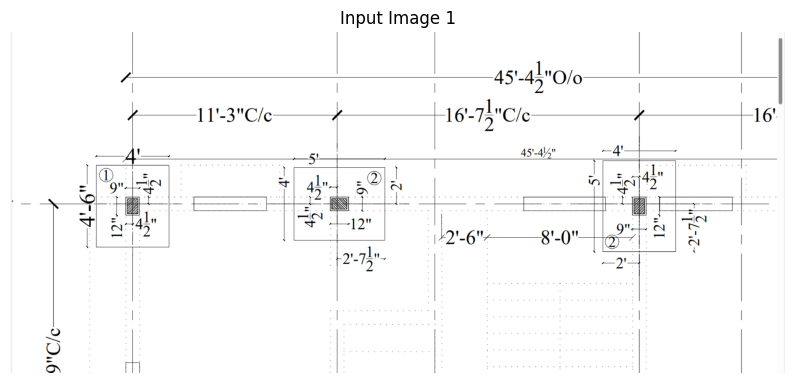

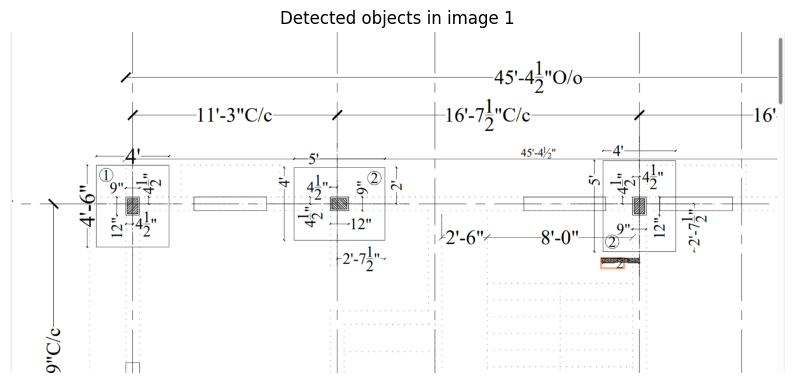

Object detection complete.

Processing detected objects in image 1...
Extracting dimensions from detected objects...
Extracted dimensions for 1 columns.

Exporting data to Excel...
Data successfully exported to column_data.xlsx

Process complete.


In [52]:
# Function to extract dimensions from detected objects
def extract_dimensions(instances, image):
    print("Extracting dimensions from detected objects...")
    columns_data = []
    for i in range(len(instances)):
        instance = instances[i]
        box = instance.pred_boxes.tensor.numpy()[0]
        column_width = box[2] - box[0]
        column_height = box[3] - box[1]
        columns_data.append({
            "Column Number": i + 1,
            "Column Length (meters)": column_height / 100,
            "Column Width (meters)": column_width / 100
        })
    print(f"Extracted dimensions for {len(columns_data)} columns.\n")
    return columns_data

# Function to export data to Excel
def export_to_excel(data, output_path):
    print("Exporting data to Excel...")
    df = pd.DataFrame(data)
    df.to_excel(output_path, index=False)
    print(f"Data successfully exported to {output_path}\n")

# Main function to execute the pipeline
def main(pdf_path, output_excel_path):
    images = pdf_to_images(pdf_path)
    cfg, predictor = configure_detectron2()
    detected_results = detect_objects(images, predictor, cfg)
    
    all_columns_data = []
    for img_idx, (visualized_image, instances) in enumerate(detected_results):
        print(f"Processing detected objects in image {img_idx + 1}...")
        columns_data = extract_dimensions(instances, images[img_idx])
        all_columns_data.extend(columns_data)
    
    export_to_excel(all_columns_data, output_excel_path)
    print("Process complete.")

# Execute the main function
if __name__ == "__main__":
    pdf_path = r"C:\OCR\Centerline_test.pdf"  # Specify the path to the PDF file
    output_excel_path = "column_data.xlsx"
    main(pdf_path, output_excel_path)

In [ ]:
Trying method 2

In [53]:
# Register the COCO dataset
def register_datasets():
    register_coco_instances("column_train", {}, "C:/OCR/Column-Data-Detection.v2i.coco/train/_annotations.coco.json", "C:/OCR/Column-Data-Detection.v2i.coco/train")
    register_coco_instances("column_val", {}, "C:/OCR/Column-Data-Detection.v2i.coco/valid/_annotations.coco.json", "C:/OCR/Column-Data-Detection.v2i.coco/valid")

    print("Datasets registered.")

In [55]:
pip install 'git+https://github.com/facebookresearch/detectron2.git'


Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: "'git+https://github.com/facebookresearch/detectron2.git'"


In [56]:
# Import necessary libraries
import os
import torch
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2 import model_zoo

# Continue with the rest of your code


In [62]:
# Function to configure and train the model
def train_model(output_dir):
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
    cfg.DATASETS.TRAIN = ("column_train",)
    cfg.DATASETS.TEST = ("column_val",)
    cfg.DATALOADER.NUM_WORKERS = 2
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Use pre-trained weights
    cfg.SOLVER.IMS_PER_BATCH = 2
    cfg.SOLVER.BASE_LR = 0.00025  # Learning rate
    cfg.SOLVER.MAX_ITER = 500    # Maximum iterations
    cfg.SOLVER.STEPS = []         # No learning rate decay
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 5  # Update with the correct number of classes
    cfg.MODEL.DEVICE = 'cpu'


    cfg.OUTPUT_DIR = output_dir

    os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
    trainer = DefaultTrainer(cfg) 
    trainer.resume_or_load(resume=False)
    trainer.train()

    print("Training complete.")

register_datasets()
train_model("C:/OCR/Output1")

Datasets registered.
[08/09 20:20:42 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
       

model_final_280758.pkl: 167MB [00:19, 8.52MB/s]                
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (6, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (6,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (20, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (20,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bb

[08/09 20:21:02 d2.engine.train_loop]: Starting training from iteration 0
[08/09 20:32:09 d2.utils.events]:  eta: 3:53:57  iter: 19  total_loss: 2.591  loss_cls: 1.945  loss_box_reg: 0.3123  loss_rpn_cls: 0.2673  loss_rpn_loc: 0.03208    time: 31.5006  last_time: 29.1503  data_time: 0.7034  last_data_time: 0.0093   lr: 9.7405e-06  
[08/09 20:42:56 d2.utils.events]:  eta: 3:54:49  iter: 39  total_loss: 2.379  loss_cls: 1.643  loss_box_reg: 0.531  loss_rpn_cls: 0.1505  loss_rpn_loc: 0.02917    time: 31.9158  last_time: 28.2390  data_time: 0.0052  last_data_time: 0.0027   lr: 1.9731e-05  
[08/09 20:54:57 d2.utils.events]:  eta: 4:00:58  iter: 59  total_loss: 1.946  loss_cls: 1.196  loss_box_reg: 0.6133  loss_rpn_cls: 0.1017  loss_rpn_loc: 0.02635    time: 33.3351  last_time: 44.7049  data_time: 0.0043  last_data_time: 0.0079   lr: 2.972e-05  
[08/09 21:07:40 d2.utils.events]:  eta: 4:00:14  iter: 79  total_loss: 1.93  loss_cls: 0.9463  loss_box_reg: 0.8468  loss_rpn_cls: 0.08627  loss_rpn

In [63]:
# Import necessary libraries
import fitz  # PyMuPDF
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from openpyxl import Workbook

# Function to convert PDF pages to images
def pdf_to_images(pdf_path):
    print("Converting PDF to images...")
    pdf_document = fitz.open(pdf_path)
    images = []
    for page_num in range(len(pdf_document)):
        page = pdf_document.load_page(page_num)
        pix = page.get_pixmap(dpi=300)
        img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
        images.append(np.array(img))
        print(f"Extracted image from page {page_num + 1}")
    print("PDF conversion complete.\n")
    return images

In [64]:
# Function to configure and load the Detectron2 model
def configure_detectron2():
    print("Configuring Detectron2 model...")
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.3  # Lowered threshold for more detections
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 5  # Ensure this matches your model's trained classes
    cfg.MODEL.WEIGHTS = "C:/OCR/Output/model_final.pth"  # Path to your model file
    cfg.MODEL.DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    print("Detectron2 configuration complete.\n")
    return cfg, DefaultPredictor(cfg)

# Function to process images using Detectron2 model
def detect_objects(images, predictor, cfg):
    print("Detecting objects in images...")
    results = []
    for i, image in enumerate(images):
        outputs = predictor(image)
        instances = outputs["instances"]
        num_instances = len(instances)
        print(f"Objects detected in image {i + 1}: {num_instances} instances found.")
        
        # Visualize the input image
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        plt.title(f"Input Image {i + 1}")
        plt.axis('off')
        plt.show()

        if num_instances > 0:
            v = Visualizer(image[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
            out = v.draw_instance_predictions(instances.to("cpu"))
            
            # Display the detected objects
            plt.figure(figsize=(10, 10))
            plt.imshow(out.get_image()[:, :, ::-1])
            plt.title(f"Detected objects in image {i + 1}")
            plt.axis('off')
            plt.show()
        
        results.append((image, instances))
    print("Object detection complete.\n")
    return results

# Function to extract dimensions from detected objects
def extract_dimensions(instances, image):
    print("Extracting dimensions from detected objects...")
    columns_data = []
    for i in range(len(instances)):
        instance = instances[i]
        box = instance.pred_boxes.tensor.numpy()[0]
        column_width = box[2] - box[0]
        column_height = box[3] - box[1]
        columns_data.append({
            "Column Number": i + 1,
            "Column Length (meters)": column_height / 100,
            "Column Width (meters)": column_width / 100
        })
    print(f"Extracted dimensions for {len(columns_data)} columns.\n")
    return columns_data


Converting PDF to images...
Extracted image from page 1
PDF conversion complete.

Configuring Detectron2 model...
Detectron2 configuration complete.

[08/10 01:19:44 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from C:/OCR/Output/model_final.pth ...


C:\Users\malar\anaconda3\envs\OCR\lib\site-packages\fvcore\common\checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.de

Detecting objects in images...
Objects detected in image 1: 14 instances found.


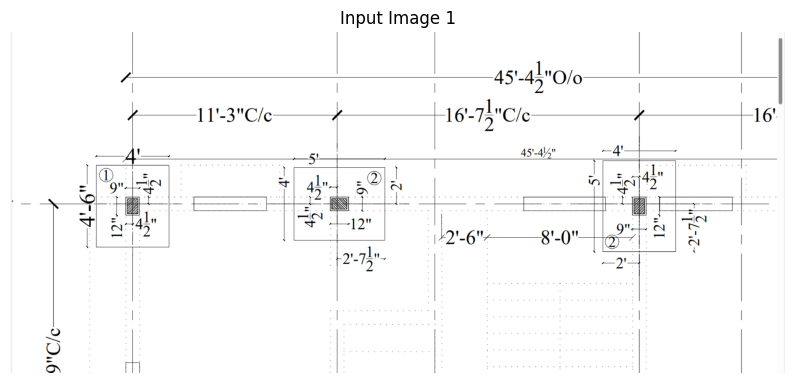

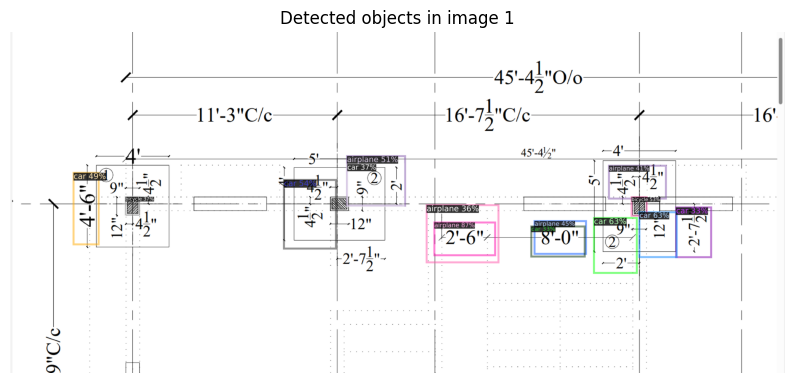

Object detection complete.

Processing detected objects in image 1...
Extracting dimensions from detected objects...
Extracted dimensions for 14 columns.

Exporting data to Excel...
Data successfully exported to column_data.xlsx

Process complete.


In [65]:
# Function to export data to Excel
def export_to_excel(data, output_path):
    print("Exporting data to Excel...")
    df = pd.DataFrame(data)
    df.to_excel(output_path, index=False)
    print(f"Data successfully exported to {output_path}\n")

# Main function to execute the pipeline
def main(pdf_path, output_excel_path):
    images = pdf_to_images(pdf_path)
    cfg, predictor = configure_detectron2()
    detected_results = detect_objects(images, predictor, cfg)
    
    all_columns_data = []
    for img_idx, (image, instances) in enumerate(detected_results):
        print(f"Processing detected objects in image {img_idx + 1}...")
        columns_data = extract_dimensions(instances, image)
        all_columns_data.extend(columns_data)
    
    export_to_excel(all_columns_data, output_excel_path)
    print("Process complete.")

# Execute the main function
if __name__ == "__main__":
    pdf_path = r"C:\OCR\Centerline_test.pdf"  # Specify the path to the PDF file
    output_excel_path = "column_data.xlsx"
    main(pdf_path, output_excel_path)
